In [100]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [101]:
population_df = pd.read_csv('../data/PopByAgeGroupSupplemented.csv', index_col='Year')
birth_death_df = pd.read_csv('../data/BirthsDeathsByQuarter.csv')
migration_df = pd.read_csv('../data/NetMigrationByYear.csv', index_col='Year')

# Change unit of births and deaths to be in thousands of people
birth_death_df['Births Registered (Number)'] = birth_death_df['Births Registered (Number)'] / 1000.0
birth_death_df['Deaths Registered (Number)'] = birth_death_df['Deaths Registered (Number)'] / 1000.0

# Sum quarterly births and deaths to yearly totals
birth_death_df['Year'] = birth_death_df['Quarter'].str[:4].astype(int)
birth_death_annual = birth_death_df.groupby('Year')[['Births Registered (Number)', 'Deaths Registered (Number)']].sum()

combined_df = pd.merge(migration_df, birth_death_annual, left_index=True, right_index=True, how='outer')
combined_df = pd.merge(combined_df, population_df, left_index=True, right_index=True, how='outer')
combined_df.drop(columns=['Country', 'Origin or Destination', 'STATISTIC', 'UNIT'], axis=1, inplace=True)

combined_df = combined_df[combined_df.index >= 1987]
combined_df.tail()

,Estimated Migration (Persons in April) (Thousand),Births Registered (Number),Deaths Registered (Number),Under 1 year,1 - 4 years,5 - 9 years,10 - 14 years,15 - 19 years,20 - 24 years,25 - 29 years,...,40 - 44 years,45 - 49 years,50 - 54 years,55 - 59 years,60 - 64 years,65 - 69 years,70 - 74 years,75 - 79 years,80 - 84 years,85 years and over
Year,,,,,,,,,,,,,,,,,,,,,
2020,44.7,55.959,31.765,58.2,250.5,350.2,354.7,327.4,310.5,296.4,...,394.3,362.6,319.9,296.0,261.6,228.7,192.5,138.5,90.8,75.6
2021,21.8,58.443,33.055,55.9,245.0,342.7,364.0,329.0,311.4,294.8,...,403.6,368.2,329.5,301.2,268.5,234.1,196.2,147.2,92.4,77.5
2022,51.7,57.540,35.477,57.7,238.2,343.6,374.9,337.8,311.9,299.1,...,414.7,376.0,342.9,309.7,275.8,240.5,204.7,155.0,96.8,84.4
2023,77.7,54.678,35.459,55.7,238.1,338.6,379.2,349.5,317.8,308.5,...,427.7,382.7,354.5,316.3,285.2,244.8,210.5,162.1,101.8,87.1
2024,79.3,40.645,26.934,55.5,237.7,335.3,381.8,359.0,322.2,320.2,...,435.0,393.6,365.1,322.4,295.2,251.3,214.7,169.2,106.9,91.2


In [102]:
# Checking stationarity of each column
non_stationary_columns = []

def check_stationarity(df, columns=None):
    if columns is None:  # by default check all columns
        columns = df.columns

    non_stationary_columns.clear()

    for column in columns:
        result = adfuller(df[column].dropna())
        print(f'{column}: ADF Statistic = {result[0]}, p-value = {result[1]}')
        # p-value >= 0.05 means non-stationary
        if result[1] >= 0.05:
            non_stationary_columns.append(column)

differencing_orders = {col: 0 for col in combined_df.columns} # for tracking order of differencing

def difference_columns(df, columns, order=1):
    for column in columns:
        for _ in range(order):
            df[column] = df[column].diff()
        df[column] = df[column].dropna()
        
        differencing_orders[column] += order

check_stationarity(combined_df)

print(f'\nNon stationary columns:\n{non_stationary_columns}')

Estimated Migration (Persons in April) (Thousand): ADF Statistic = -3.116421912043417, p-value = 0.025361522732072452
Births Registered (Number): ADF Statistic = -1.6545971855732036, p-value = 0.4546439725929949
Deaths Registered (Number): ADF Statistic = -2.6747278604242606, p-value = 0.07851447449790619
Under 1 year: ADF Statistic = -1.3723474470418735, p-value = 0.5954589805319652
1 - 4 years: ADF Statistic = -2.304173512556487, p-value = 0.17062546362592756
5 - 9 years: ADF Statistic = -4.285966106152663, p-value = 0.00046973724186180675
10 - 14 years: ADF Statistic = -1.8801279310383816, p-value = 0.3414665232849442
15 - 19 years: ADF Statistic = -3.8092075821566413, p-value = 0.0028145018608141618
20 - 24 years: ADF Statistic = -2.8129950795407024, p-value = 0.05644135579263423
25 - 29 years: ADF Statistic = -2.317878415183776, p-value = 0.16626664231260602
30 - 34 years: ADF Statistic = -2.0634830714010923, p-value = 0.2594493880475565
35 - 39 years: ADF Statistic = -4.064970186

In [103]:
combined_df.index = pd.to_datetime(combined_df.index, format='%Y')
combined_df.fillna(0, inplace=True)
combined_df.head()

,Estimated Migration (Persons in April) (Thousand),Births Registered (Number),Deaths Registered (Number),Under 1 year,1 - 4 years,5 - 9 years,10 - 14 years,15 - 19 years,20 - 24 years,25 - 29 years,...,40 - 44 years,45 - 49 years,50 - 54 years,55 - 59 years,60 - 64 years,65 - 69 years,70 - 74 years,75 - 79 years,80 - 84 years,85 years and over
Year,,,,,,,,,,,,,,,,,,,,,
1987-01-01,-23.0,58.864,31.219,60.200,255.100,352.000,347.100,329.400,286.400,256.100,...,202.800,161.900,150.800,140.100,139.300,129.100,111.100,78.000,43.700,26.30
1988-01-01,-41.9,54.300,31.575,57.300,246.400,349.300,340.900,330.000,278.800,251.000,...,209.200,168.200,149.300,141.900,136.200,132.900,107.700,81.600,43.900,27.10
1989-01-01,-43.9,51.659,31.103,53.400,238.900,341.600,339.600,327.200,270.400,246.500,...,216.300,172.100,151.000,141.300,135.400,133.300,107.500,83.300,45.300,28.00
1990-01-01,-22.9,52.954,31.818,51.700,230.500,328.700,343.700,328.300,265.800,246.100,...,221.900,177.800,154.400,141.500,134.400,132.300,107.800,84.500,47.100,28.30
1991-01-01,-2.0,52.690,31.498,53.044,220.699,318.503,348.328,335.026,266.572,246.321,...,225.683,187.762,156.806,142.549,134.566,130.752,109.325,84.082,49.301,29.44


In [104]:
# scaler = StandardScaler()
# combined_df_scaled = pd.DataFrame(scaler.fit_transform(combined_df), columns=combined_df.columns, index=combined_df.index)

In [105]:
selected_columns = ["Estimated Migration (Persons in April) (Thousand)",
                    "Births Registered (Number)",
                    "Deaths Registered (Number)",
                    '60 - 64 years',
                    '65 - 69 years']
df_selected = combined_df[selected_columns]

In [106]:
check_stationarity(df_selected)
print(f'\nNon stationary columns:\n{non_stationary_columns}')

Estimated Migration (Persons in April) (Thousand): ADF Statistic = -3.116421912043417, p-value = 0.025361522732072452
Births Registered (Number): ADF Statistic = -1.6545971855732036, p-value = 0.4546439725929949
Deaths Registered (Number): ADF Statistic = -2.6747278604242606, p-value = 0.07851447449790619
60 - 64 years: ADF Statistic = 4.1887089601048215, p-value = 1.0
65 - 69 years: ADF Statistic = 0.2283245332067748, p-value = 0.973806228507363

Non stationary columns:
['Births Registered (Number)', 'Deaths Registered (Number)', '60 - 64 years', '65 - 69 years']


In [107]:
df_selected_copy = df_selected.copy()
df_selected = df_selected.diff().dropna()
df_selected = df_selected.diff().dropna()
check_stationarity(df_selected)
print(f'\nNon stationary columns:\n{non_stationary_columns}')

Estimated Migration (Persons in April) (Thousand): ADF Statistic = -5.343816455901086, p-value = 4.440107176888056e-06
Births Registered (Number): ADF Statistic = -4.260445660113929, p-value = 0.0005197377924360544
Deaths Registered (Number): ADF Statistic = -3.2479940823547078, p-value = 0.017369334357483227
60 - 64 years: ADF Statistic = -10.633598062162884, p-value = 5.139400300186351e-19
65 - 69 years: ADF Statistic = -9.0135868348872, p-value = 6.033664665549313e-15

Non stationary columns:
[]


In [108]:
df_selected.head()

,Estimated Migration (Persons in April) (Thousand),Births Registered (Number),Deaths Registered (Number),60 - 64 years,65 - 69 years
Year,,,,,
1989-01-01,16.9,1.923,-0.828,2.300,-3.400
1990-01-01,23.0,3.936,1.187,-0.200,-1.400
1991-01-01,-0.1,-1.559,-1.035,1.166,-0.548
1992-01-01,-11.5,-0.842,-0.398,-0.132,0.996
1993-01-01,-17.2,-1.022,1.594,1.566,-1.448


In [109]:
# Finding optimal number of lags
model = VAR(df_selected)
lag_order = model.select_order(maxlags=5)
print(lag_order.summary())

optimal_lag = lag_order.bic
print(f"Optimal # of lags: {optimal_lag}")

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       13.34       13.58   6.245e+05       13.42
1       12.98       14.37   4.452e+05       13.43
2       12.01       14.55   1.930e+05       12.84
3       12.08       15.78   3.052e+05       13.29
4       9.579       14.44   6.279e+04       11.16
5      7.148*      13.16*  5.574e+04*      9.108*
-------------------------------------------------
Optimal # of lags: 5


C:\Users\bayan\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [110]:
# Fitting the model
var_fitted = model.fit(optimal_lag)
var_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 24, Mar, 2025
Time:                     00:14:00
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    13.1611
Nobs:                     31.0000    HQIC:                   9.10781
Log likelihood:          -200.723    FPE:                    55744.1
AIC:                      7.14756    Det(Omega_mle):         2652.36
--------------------------------------------------------------------
Results for equation Estimated Migration (Persons in April) (Thousand)
                                                          coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------------------------
const                                                        4.293831         4.415389            0.

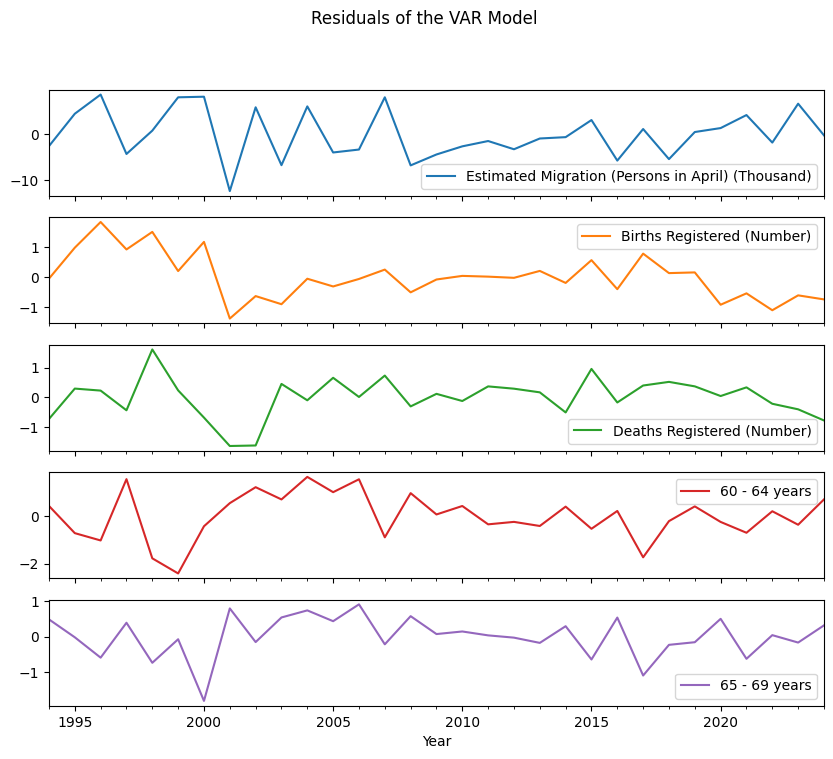

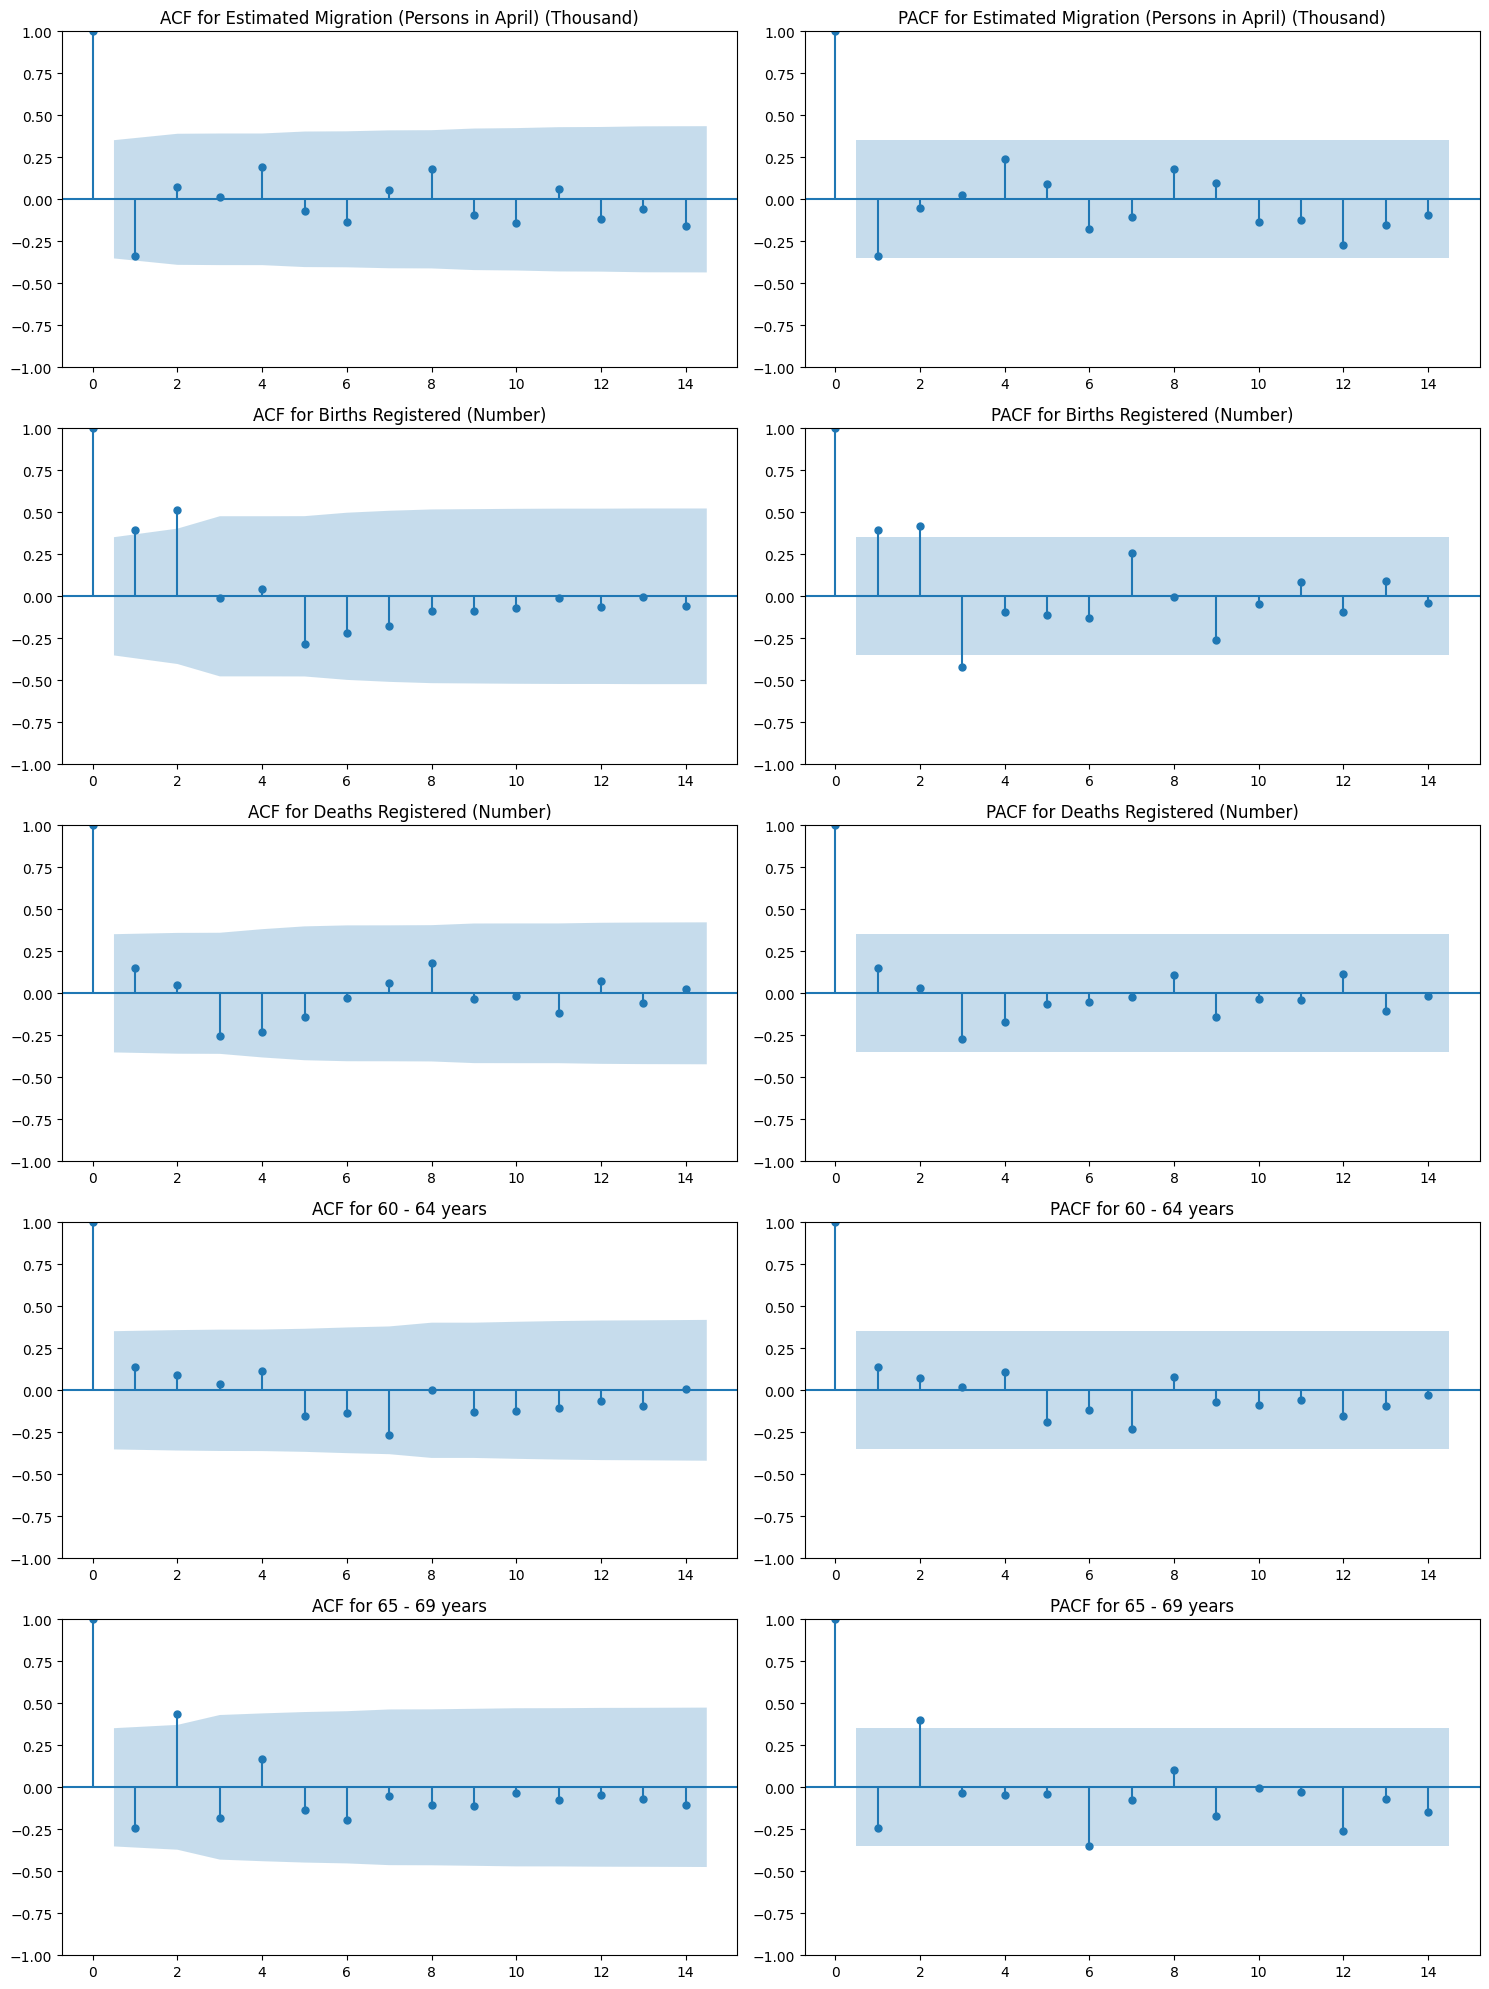

In [111]:
residuals = var_fitted.resid

residuals.plot(subplots=True, figsize=(10, 8), title="Residuals of the VAR Model")
plt.show()

fig, axes = plt.subplots(len(residuals.columns), 2, figsize=(15, 20))
axes = axes.flatten()

for i, column in enumerate(residuals.columns):
    lags = min(40, len(residuals[column]) // 2 - 1)

    ax_acf = axes[i * 2]
    plot_acf(residuals[column], lags=lags, ax=ax_acf)
    ax_acf.set_title(f'ACF for {column}')

    ax_pacf = axes[i * 2 + 1]
    plot_pacf(residuals[column], lags=lags, ax=ax_pacf)
    ax_pacf.set_title(f'PACF for {column}')

plt.tight_layout()
plt.show()

Estimated Migration (Persons in April) (Thousand) RMSE: 257.014322873287 MSE: 66056.36216201424
Births Registered (Number) RMSE: 250.66242505413885 MSE: 62831.65133402178
Deaths Registered (Number) RMSE: 150.70997798543056 MSE: 22713.497464368964
60 - 64 years RMSE: 49.205678827425494 MSE: 2421.19882886775
65 - 69 years RMSE: 135.30723747721404 MSE: 18308.048513715195


C:\Users\bayan\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


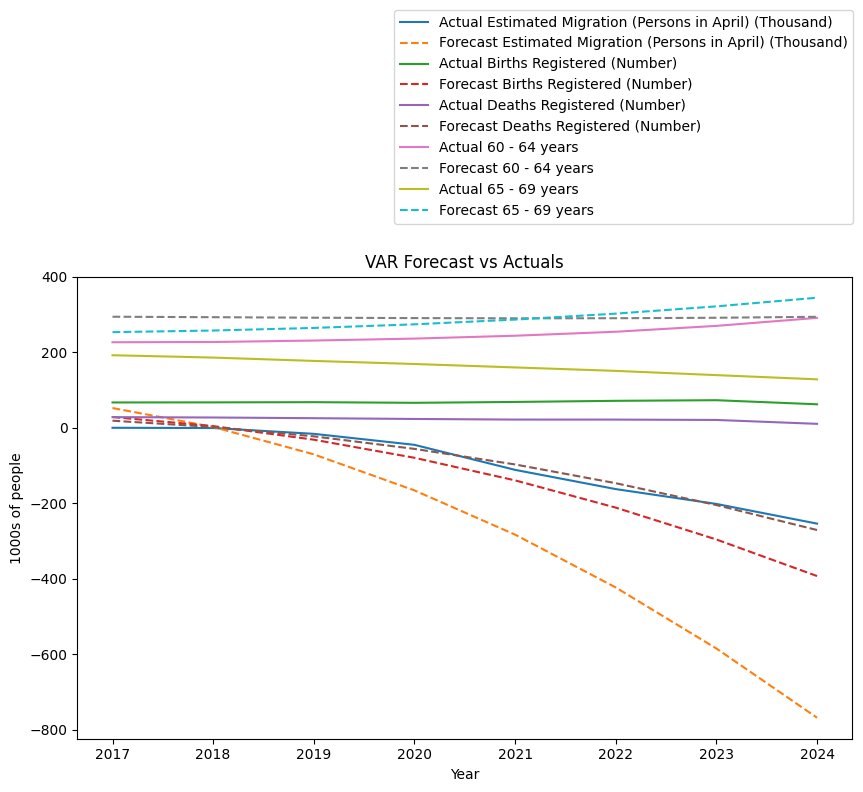

In [112]:
# Evaluation
train_size = int(len(df_selected) * 0.8)
train_data, test_data = df_selected[:train_size], df_selected[train_size:]

model_train = VAR(train_data)
lag_order_train = model_train.select_order(maxlags=3).bic
var_fitted_train = model_train.fit(lag_order_train)

forecast_steps = len(test_data)
forecast = var_fitted_train.forecast(train_data.values[-lag_order_train:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=test_data.columns)

forecast_df = forecast_df.cumsum() + df_selected.iloc[-1]
test_data = test_data.cumsum() + df_selected.iloc[:train_size].iloc[-1]

forecast_df_first_cumsum = forecast_df.cumsum()
forecast_df = forecast_df_first_cumsum.cumsum() + df_selected_copy.iloc[-1]

test_data_first_cumsum = test_data.cumsum()
test_data = test_data_first_cumsum.cumsum() + df_selected_copy.iloc[:train_size].iloc[-1]

for column in test_data.columns:
    rmse = metrics.root_mean_squared_error(test_data[column], forecast_df[column])
    mse = metrics.mean_squared_error(test_data[column], forecast_df[column])
    print(f'{column} RMSE: {rmse} MSE: {mse}')
    
plt.figure(figsize=(10, 6))
for column in test_data.columns:
    plt.plot(test_data.index, test_data[column], label=f"Actual {column}")
    plt.plot(forecast_df.index, forecast_df[column], label=f"Forecast {column}", linestyle='--')

plt.legend(bbox_to_anchor=(0.4, 1.1))
plt.xlabel('Year')
plt.ylabel('1000s of people')
plt.title('VAR Forecast vs Actuals')
plt.show()

C:\Users\bayan\AppData\Local\Temp\ipykernel_16176\230590073.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=combined_df.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='Y'), columns=df_selected.columns)


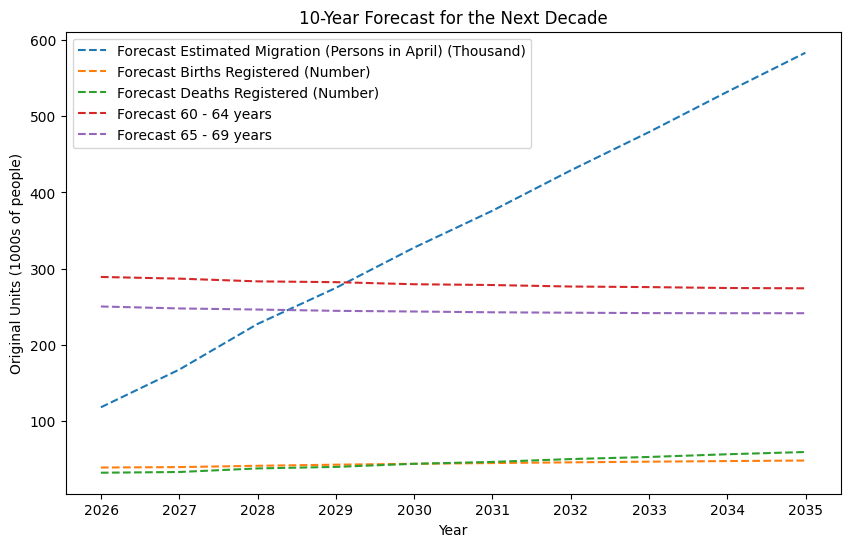

In [113]:
# Forecasting

forecast_steps = 10
last_data = df_selected.iloc[-lag_order_train:]

forecast = var_fitted_train.forecast(last_data.values, steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=combined_df.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='Y'), columns=df_selected.columns)

forecast_first_cumsum = forecast_df.cumsum()
forecast_original_units = forecast_first_cumsum.cumsum() + df_selected_copy.iloc[-1]

plt.figure(figsize=(10, 6))
for column in forecast_original_units.columns:
    plt.plot(forecast_original_units.index, forecast_original_units[column], label=f"Forecast {column}", linestyle='--')

plt.xlabel('Year')
plt.ylabel('Original Units (1000s of people)')
plt.title('10-Year Forecast for the Next Decade')
plt.legend()
plt.show()